<a href="https://colab.research.google.com/github/mallickboy/stable-diffusion-finetune/blob/main/Train_loraSDX1_naruto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Core dependencies

In [ ]:
!pip install -qqq torch torchvision torchaudio
!pip install -qqq accelerate bitsandbytes
!pip install -qqq transformers peft
!pip install -qqq datasets Pillow tensorboard
!pip install -qqq "huggingface_hub[cli]"

!pip install -qqq git+https://github.com/huggingface/diffusers.git
# Lora finetune base script
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py


import locale
locale.getpreferredencoding = lambda: "UTF-8"
!accelerate config default

!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml
Tue Nov 25 18:04:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=================================

## Save checkpoint in Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output"
!mkdir -p $OUTPUT_DIR

Mounted at /content/drive


In [ ]:
# from huggingface_hub import login
# import os
# from getpass import getpass

# HF_TOKEN = getpass("Hugging Face token (input hidden): ")

# HUB_MODEL_ID = "tamalmallick/sdxl-lora-naruto-style"

# login(token=HF_TOKEN, add_to_git_credential=False)
# os.environ["HUGGINGFACE_TOKEN"] = HF_TOKEN

# print(f"Successfully logged in. Ready to push LoRA weights to: {HUB_MODEL_ID}")


Hugging Face token (input hidden): ··········
Successfully logged in. Ready to push LoRA weights to: tamalmallick/sdxl-lora-naruto-style


## Initial test training

In [ ]:
MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
DATASET_NAME="lambdalabs/naruto-blip-captions"
RANK=16

MAX_TRAIN_STEPS=200
LEARNING_RATE="1e-4"
OUTPUT_DIR="/content/drive/MyDrive/naruto_sdxl_lora_output"
CHECKPOINT_STEPS=5

CHECKPOINT_PATH="$OUTPUT_DIR/checkpoint-5"
resume_flag = f"--resume_from_checkpoint={CHECKPOINT_PATH}" if os.path.exists(CHECKPOINT_PATH) else ""

print("Starting SDXL LoRA Fine-Tuning with T4 Optimizations...")
!accelerate launch train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --output_dir=$OUTPUT_DIR \
  --caption_column="text" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=8 \
  --gradient_checkpointing \
  --use_8bit_adam \
  --rank=$RANK \
  --learning_rate=$LEARNING_RATE \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --checkpointing_steps=$CHECKPOINT_STEPS \
  --seed=42 \
  --snr_gamma=5.0 \
  --mixed_precision="bf16" \
  $resume_flag

Starting SDXL LoRA Fine-Tuning with T4 Optimizations...
2025-11-24 05:44:33.367041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763963073.399005   11111 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763963073.408946   11111 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763963073.432861   11111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763963073.432899   11111 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763963073.432909  

###### Outcome: saved 1 ckpt at 5th step then finetuned and and saved update after another 5 step , total steps = 10
- Explored and learned mixed_precision="bf16" not that great for T4 GPU

### Test Train with low Resolution
- With reduced res and higher batch size as images have basic detailings in them

In [ ]:
OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
!mkdir -p $OUTPUT_DIR

In [ ]:
# --- Configuration Variables ---
MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
DATASET_NAME="lambdalabs/naruto-blip-captions"
RANK=16

MAX_TRAIN_STEPS=200
LEARNING_RATE="1e-4"
OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
CHECKPOINT_STEPS=5

CHECKPOINT_PATH="$OUTPUT_DIR/checkpoint-200"
resume_flag = f"--resume_from_checkpoint={CHECKPOINT_PATH}" if os.path.exists(CHECKPOINT_PATH) else ""
print("Resume flag: ",resume_flag)

print("Starting SDXL LoRA Fine-Tuning with T4 Optimizations...")
!accelerate launch train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --output_dir=$OUTPUT_DIR \
  --caption_column="text" \
  --resolution=256 \
  --train_batch_size=12 \
  --gradient_accumulation_steps=8 \--gradient_checkpointing \
  --use_8bit_adam \
  --rank=$RANK \
  --learning_rate=$LEARNING_RATE \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --checkpointing_steps=$CHECKPOINT_STEPS \
  --seed=42 \
  --snr_gamma=5.0 \
  --mixed_precision="fp16" \
  $resume_flag

Resume flag:  
Starting SDXL LoRA Fine-Tuning with T4 Optimizations...
2025-11-24 06:03:20.178042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763964200.197912   15901 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763964200.203954   15901 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763964200.219203   15901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763964200.219228   15901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763

In [ ]:
# --train_batch_size=12
# --gradient_accumulation_steps=8
# 1 Optimizer step = 12 * 8 = 96
# 1 epoch = 1221 (total training images) / 96 = 12.7 = 13 steps

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
!mkdir -p $OUTPUT_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Inference

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, EulerAncestralDiscreteScheduler
from PIL import Image

# --- configuration ---
MODEL_NAME = "stabilityai/stable-diffusion-xl-base-1.0"
VAE_MODEL_NAME = "madebyollin/sdxl-vae-fp16-fix"
OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_256"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoint-200")
LORA_WEIGHTS_PATH = os.path.join(CHECKPOINT_DIR, "pytorch_lora_weights.safetensors")

INFER_DIR = os.path.join(OUTPUT_DIR, "inference-2")
os.makedirs(INFER_DIR, exist_ok=True)

NEGATIVE_PROMPT = "low quality, blurry, worst quality, noise, bad anatomy, deformed"
SEED = 42
SCHEDULER = EulerAncestralDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
DTYPE = torch.float16
GENERATOR = torch.Generator("cuda").manual_seed(SEED)


# --- Utility: Initialize Pipeline ---
def _initialize_pipeline(lora_path=None):
    print("Loading VAE with FP16 fix...")
    vae = AutoencoderKL.from_pretrained(VAE_MODEL_NAME, torch_dtype=DTYPE).to("cuda")

    print("Loading SDXL Pipeline (with CPU Offload)...")
    pipe = StableDiffusionXLPipeline.from_pretrained(
        MODEL_NAME,
        vae=vae,
        scheduler=SCHEDULER,
        torch_dtype=DTYPE,
        variant="fp16"
    )
    pipe.enable_model_cpu_offload()
    pipe.enable_vae_tiling()

    if lora_path and os.path.exists(lora_path):
        print(f"Loading LoRA weights from: {lora_path}")
        pipe.load_lora_weights(lora_path)
    elif lora_path:
        print(f"WARNING: LoRA weights not found at: {lora_path}")
    return pipe


In [ ]:
def inf_base(prompts):
    print("Running Base SDXL inference...")
    pipe = _initialize_pipeline(lora_path=None)

    results = []
    for i, prompt in enumerate(prompts, 1):
        GENERATOR.manual_seed(SEED)
        print(f"Generating base image {i}/{len(prompts)}...")
        image = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            generator=GENERATOR,
            num_inference_steps=30,
            guidance_scale=7.5,
            output_type="pil"
        ).images[0]

        filename = os.path.join(INFER_DIR, f"base_{i+1}_{prompt[:30].replace(' ', '_').replace(',', '')}.png")
        image.save(filename)
        results.append((prompt, filename, image))
        print(f"Saved {filename}")

    # Plot results
    plt.figure(figsize=(15, len(results) * 5))
    for i, (prompt, _, image) in enumerate(results, 1):
        plt.subplot(len(results), 1, i)
        plt.imshow(image)
        plt.axis("off")
        plt.title(prompt, fontsize=12)
    plt.suptitle("Base SDXL Outputs", fontsize=16, y=0.99)
    plt.tight_layout()
    plt.show()

    del pipe
    torch.cuda.empty_cache()

Running Base SDXL inference...
Loading VAE with FP16 fix...
Loading SDXL Pipeline (with CPU Offload)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Generating base image 1/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_2_Naruto_Uzumaki_eating_ramen&qu.png
Generating base image 2/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_3_Bill_Gates_in_Naruto_style&quo.png
Generating base image 3/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/base_4_A_boy_with_blue_eyes_in_Naruto.png


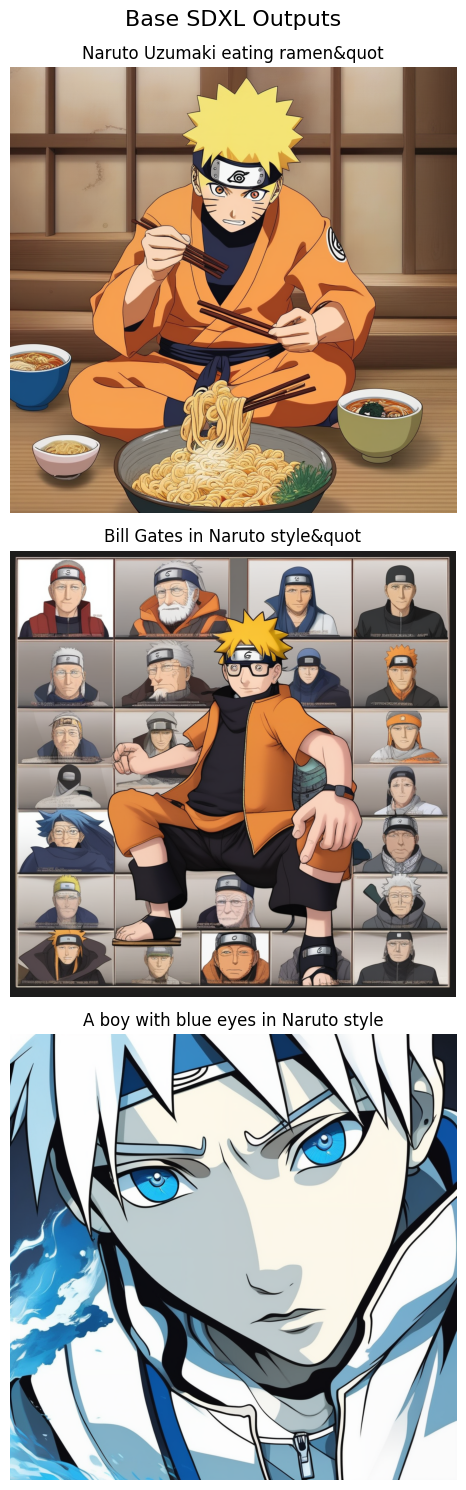

In [ ]:
prompts=[
"Naruto Uzumaki eating ramen&quot",
"Bill Gates in Naruto style&quot",
"A boy with blue eyes in Naruto style",
]
inf_base(prompts)

In [ ]:
def inf_lora(prompts):
    print(f"Running Fine-Tuned LoRA inference with {LORA_WEIGHTS_PATH}...")
    pipe = _initialize_pipeline(lora_path=LORA_WEIGHTS_PATH)

    results = []
    for i, prompt in enumerate(prompts, 1):
        GENERATOR.manual_seed(SEED)
        print(f"Generating LoRA image {i}/{len(prompts)}...")
        image = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            generator=GENERATOR,
            num_inference_steps=30,
            guidance_scale=7.5,
            output_type="pil"
        ).images[0]

        filename = os.path.join(INFER_DIR, f"lora_{i+1}_{prompt[:30].replace(' ', '_').replace(',', '')}.png")
        image.save(filename)
        results.append((prompt, filename, image))
        print(f"Saved {filename}")

    # Plot results
    plt.figure(figsize=(15, len(results) * 5))
    for i, (prompt, _, image) in enumerate(results, 1):
        plt.subplot(len(results), 1, i)
        plt.imshow(image)
        plt.axis("off")
        plt.title(prompt, fontsize=12)
    plt.suptitle("Fine-Tuned Naruto LoRA Outputs", fontsize=16, y=0.99)
    plt.tight_layout()
    plt.show()

    del pipe
    torch.cuda.empty_cache()

Running Fine-Tuned LoRA inference with /content/drive/MyDrive/naruto_sdxl_lora_output_256/checkpoint-200/pytorch_lora_weights.safetensors...
Loading VAE with FP16 fix...
Loading SDXL Pipeline (with CPU Offload)...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading LoRA weights from: /content/drive/MyDrive/naruto_sdxl_lora_output_256/checkpoint-200/pytorch_lora_weights.safetensors


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating LoRA image 1/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_2_Naruto_Uzumaki_eating_ramen&qu.png
Generating LoRA image 2/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_3_Bill_Gates_in_Naruto_style&quo.png
Generating LoRA image 3/3...


  0%|          | 0/30 [00:00<?, ?it/s]

Saved /content/drive/MyDrive/naruto_sdxl_lora_output_256/inference-2/lora_4_A_boy_with_blue_eyes_in_Naruto.png


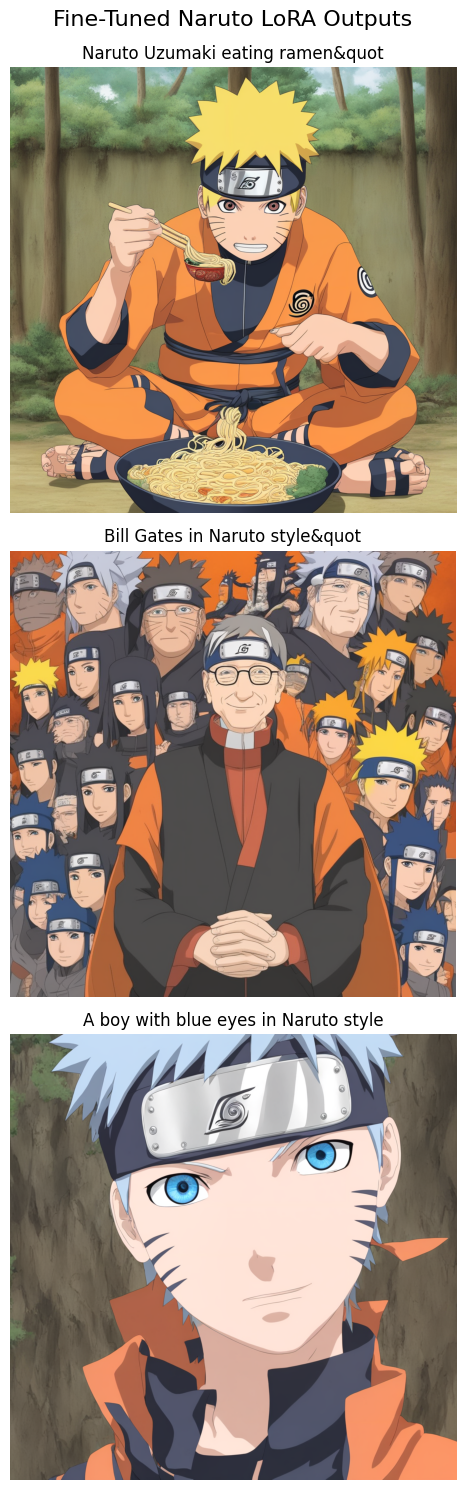

In [ ]:
prompts=[
"Naruto Uzumaki eating ramen&quot",
"Bill Gates in Naruto style&quot",
"A boy with blue eyes in Naruto style",
]
inf_lora(prompts)

# Analysis & Further Finetune 1024

In [ ]:
# --train_batch_size=12
# --gradient_accumulation_steps=8
# 1 Optimizer step = 12 * 8 = 96
# 1 epoch = 1221 (total training images) / 96 = 12.7 = 13 steps
# So next onwords I can save per 13x steps to save per x epoch

# current results are good so reduce lr from 1e-4 -> 1e-5
# increased ranbk from 16 to 24 -> 50% for better details
# steps 8 , 1 Optimizer step = 8 * 8 = 64
# 1 epoch = 1221 (total training images) / 64 = 19.07 = 20 steps (Halted this step)

## res 1024 setup
# Though 256 seemd workable compared to detailing in anime data but as the assignment requires 1024 explicitely I will continue from step 5 + 5 = 10
# --train_batch_size=1
# --gradient_accumulation_steps=8
# --mixed_precision="fp16"  use for T4 instaed of bf16 that is mainly optimized for A&H series gpu
# so current progress at 1024 res = 10* 1* 8 = 80 images trained on
# Each 5 steps cost around 7 minutes so lets push it for another 60 steps
# trained on  60*8 = 480  + 80 (old) = 560
# Ok the training seems pretty faster now with bf16-> fp16 2min/5step push it more
# 1 epoch = 1221 (total training images) / 8 = 152.6 = 153 steps
# 5 epoch = 153 * 5 = 765

# did upto 270 lr=0.0001 seems pretty high for batch of 1 image as model strted converging
# so reduce lr to 0.00003 with cosine schedular

In [ ]:
import os

MODEL_NAME="stabilityai/stable-diffusion-xl-base-1.0"
DATASET_NAME="lambdalabs/naruto-blip-captions"
RANK=16

OUTPUT_DIR = "/content/drive/MyDrive/naruto_sdxl_lora_output_1024_finetune"

CHECKPOINT_PATH= OUTPUT_DIR+"/checkpoint-300"
resume_flag = f"--resume_from_checkpoint={CHECKPOINT_PATH}" if os.path.exists(CHECKPOINT_PATH) else ""
print("Resume flag: ",resume_flag)

MAX_TRAIN_STEPS= 765
LEARNING_RATE = 3e-5 #"1e-4"
CHECKPOINT_STEPS= 30

print("Starting SDXL LoRA Fine-Tuning with T4 Optimizations...")
!accelerate launch train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --output_dir=$OUTPUT_DIR \
  --caption_column="text" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=8 \
  --gradient_checkpointing \
  --use_8bit_adam \
  --rank=$RANK \
  --learning_rate=$LEARNING_RATE \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --checkpointing_steps=$CHECKPOINT_STEPS \
  --seed=42 \
  --snr_gamma=5.0 \
  --mixed_precision="fp16" \
  $resume_flag

Resume flag:  --resume_from_checkpoint=/content/drive/MyDrive/naruto_sdxl_lora_output_1024_finetune/checkpoint-300
Starting SDXL LoRA Fine-Tuning with T4 Optimizations...
2025-11-25 21:05:22.579776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764104722.662256   46596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764104722.695617   46596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764104722.767812   46596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764104722.767859   46596 computation_placer.cc:177] computation placer already

## Done partial finetune for 1024 and for 256 resolution

In [ ]:
##